In [1]:
# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')

from pepe.preprocess import crossMask, checkImageType, rectMask, mergeMasks, circularMask
from pepe.simulate import genSyntheticResponse
from pepe.analysis import initialForceSolve, forceOptimize, gSquared
from pepe.tracking import g2HoughCircle

from scipy.signal import find_peaks
from lmfit import fit_report

import numpy as np

import cv2

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140

# For timing
import time

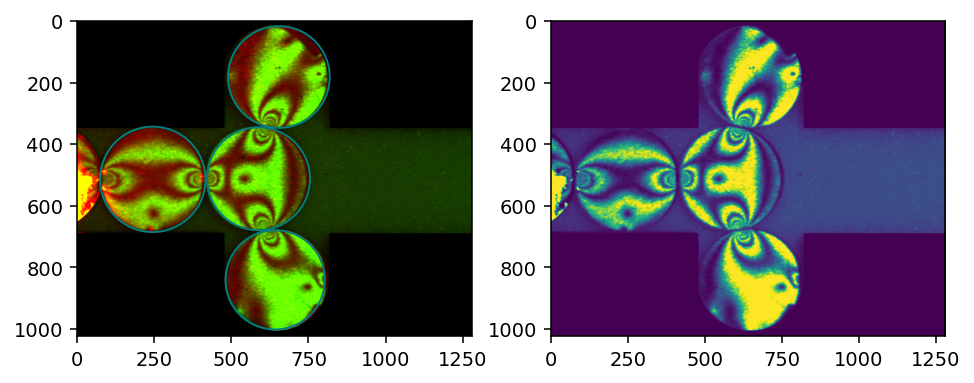

In [37]:
# Make some fake data with several potential wall contacts
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

image = checkImageType('test_data/Test_2022-01-28-3.bmp')
#photoelasticChannel = cv2.blur(image[:,:,1], (30,30))
# g2 to force conversion is calibrated on the scale [0, 1], not [0, 255]
# We also blur the images a little, since they are visibly grainy
photoelasticChannel = cv2.blur(image[:,:,1].astype(np.float64) / 255, (3,3))

centers, radii = g2HoughCircle(image[:,:,0], [160, 180], accumulatorThreshold=20, cannyEdgeThreshold=80)

centers = centers.astype(np.int64)
radii = radii.astype(np.int64)
# Make them all odd
radii += (radii % 2) == 0

# A particle is about 1cm across
pxPerMeter = 2*np.mean(radii) / .01
# No idea what the actual value for this is
fSigma = 100

# Create a cross-shaped channel, with some parts on the ends
maskArr = crossMask(image.shape, xlim=np.array([478, 818]), ylim=np.array([350, 690]))

semiCircleMask = mergeMasks(np.array([rectMask(image.shape, corner=np.array([0,400]), dimensions=np.array([200, 500])),
                             circularMask(image.shape, np.array([190, 640]), np.mean(radii)+7)]),
                           signs=np.array([1,-1], dtype=np.int16)) 

semiCircleMask2 = mergeMasks(np.array([rectMask(image.shape, corner=np.array([0,400]), dimensions=np.array([200, 500])),
                             circularMask(image.shape, np.array([190, 645]), np.mean(radii)+7)]),
                           signs=np.array([1,-1], dtype=np.int16)) 

listOfMasks = np.array([maskArr,
                       semiCircleMask,
                       semiCircleMask2[::-1]])

maskArr = mergeMasks(listOfMasks, signs=np.array([1,-1,-1], dtype=np.int16))


ax[0].imshow(maskArr * image)
for i in range(len(centers)):
    c = plt.Circle(centers[i][::-1], radii[i], label='Detected particles', color='teal', fill=False, linewidth=1)
    ax[0].add_artist(c)

ax[1].imshow(photoelasticChannel * maskArr[:,:,0])
plt.show()

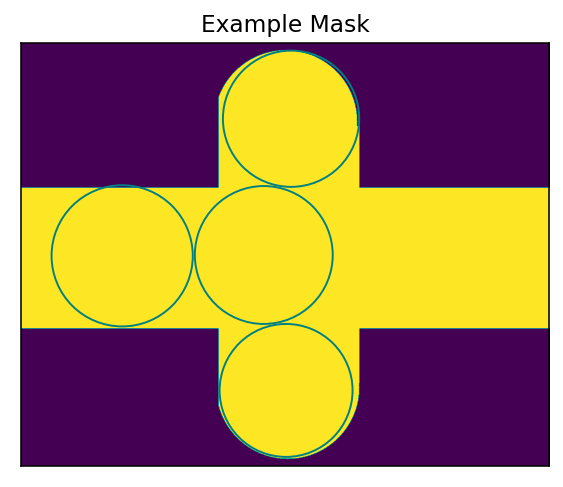

In [38]:
fig, ax = plt.subplots()

ax.imshow(maskArr[:,:,0])
ax.set_xticks([])
ax.set_yticks([])

for i in range(len(centers)):
    c = plt.Circle(centers[i][::-1], radii[i], label='Detected particles', color='teal', fill=False, linewidth=1)
    ax.add_artist(c)


ax.set_title('Example Mask')
#ax.colorbar()
#plt.savefig('../images/example_uses/example_mask.png')
plt.show()

## Find initial guess

In [39]:
# Parameters of our force solving method
contactPadding = 15
g2MaskPadding = 3
contactMaskRadius = 30
#pxPerMeter = 10000
brightfield = False

forceGuessArr, alphaGuessArr, betaGuessArr = initialForceSolve(photoelasticChannel,
                                                centers, radii, fSigma, pxPerMeter,
                                                contactPadding, g2MaskPadding,
                                                contactMaskRadius=contactMaskRadius,
                                                boundaryMask=maskArr, ignoreBoundary=False)

#forceGuessArr /= np.max([np.max(f) for f in forceGuessArr])

## Show initial guess

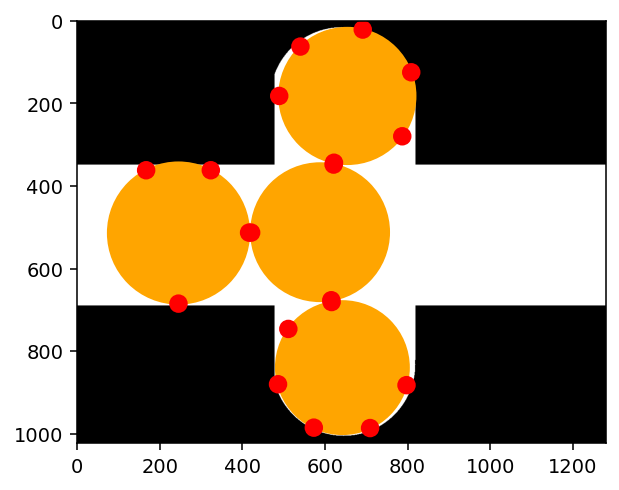

In [40]:
# Draw on all of the found contacts
fig, ax = plt.subplots()

ax.imshow(maskArr*255)

for i in range(len(centers)):
    # particle itself
    c = plt.Circle(centers[i][::-1], radii[i], label='Detected particle', color='orange')
    ax.add_artist(c)
    
    # Now add contacts
    for j in range(len(betaGuessArr[i])):
        contactPoint = centers[i] + radii[i] * np.array([np.cos(betaGuessArr[i][j]), np.sin(betaGuessArr[i][j])])
        #linePoints = np.array([centers[i], radii[i] * np.array([np.cos(betaGuessArr[i][j]), np.sin(betaGuessArr[i][j])])])
        #plt.plot(linePoints[0], linePoints[1], color='blue')
        cc = plt.Circle(contactPoint[::-1], 20, color='red')
        ax.add_artist(cc)
        
plt.show()

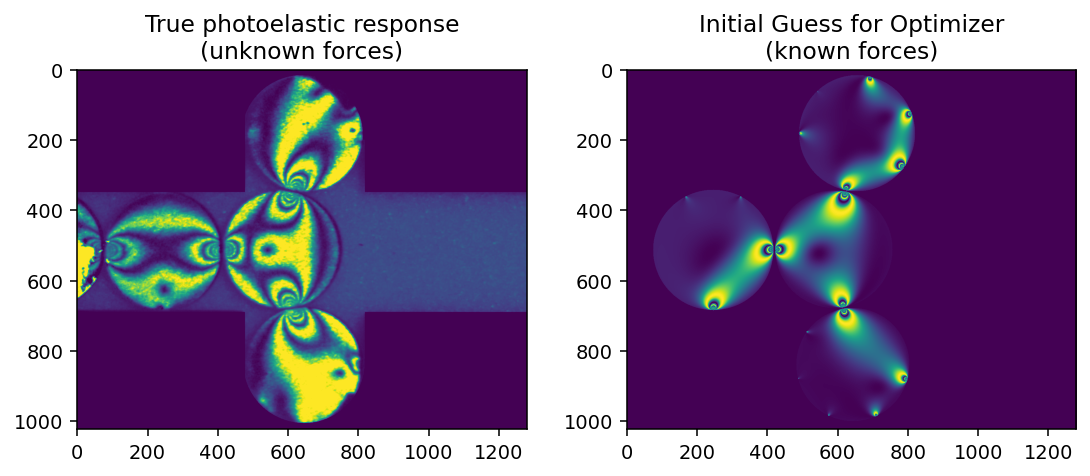

Absolute error (entire system): -171934.63403242786


In [41]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].imshow(photoelasticChannel * maskArr[:,:,0])
ax[0].set_title('True photoelastic response\n(unknown forces)')

estimatedPhotoelasticChannel = np.zeros_like(photoelasticChannel, dtype=np.float64)

for i in range(len(centers)):
    estimatedPhotoelasticChannel += genSyntheticResponse(np.array(forceGuessArr[i]),
                                                         np.array(alphaGuessArr[i]),
                                                         np.array(betaGuessArr[i]),
                                                         fSigma, radii[i],
                                                         pxPerMeter, brightfield, imageSize=photoelasticChannel.shape,
                                                         center=centers[i])


ax[1].imshow(estimatedPhotoelasticChannel)
ax[1].set_title('Initial Guess for Optimizer\n(known forces)')

fig.tight_layout()
plt.show()

print(f'Absolute error (entire system): {np.sum(estimatedPhotoelasticChannel - photoelasticChannel)}')

## Optimize forces

In [47]:
# Now optimize each particle's forces
optimizedForceArr = []
optimizedBetaArr = []
optimizedAlphaArr = []

for i in range(len(centers)):
    optForceArr, optBetaArr, optAlphaArr, res = forceOptimize(forceGuessArr[i], betaGuessArr[i], alphaGuessArr[i], radii[i], centers[i], photoelasticChannel,
                                                              fSigma, pxPerMeter, brightfield, maxEvals=[250, 150], method='nelder',
                                                              parametersToFit=[['f', 'b'], ['f', 'a']], betaTol=.4, forceTol=5., allowAddForces=True)
    optimizedForceArr.append(optForceArr)
    optimizedBetaArr.append(optBetaArr)
    optimizedAlphaArr.append(optAlphaArr)

Added 2 force(s).
Removed 1 force(s).
Removed 1 force(s).
Added 2 force(s).
Removed 1 force(s).
Removed 1 force(s).
Removed 1 force(s).
Added 1 force(s).
Removed 2 force(s).


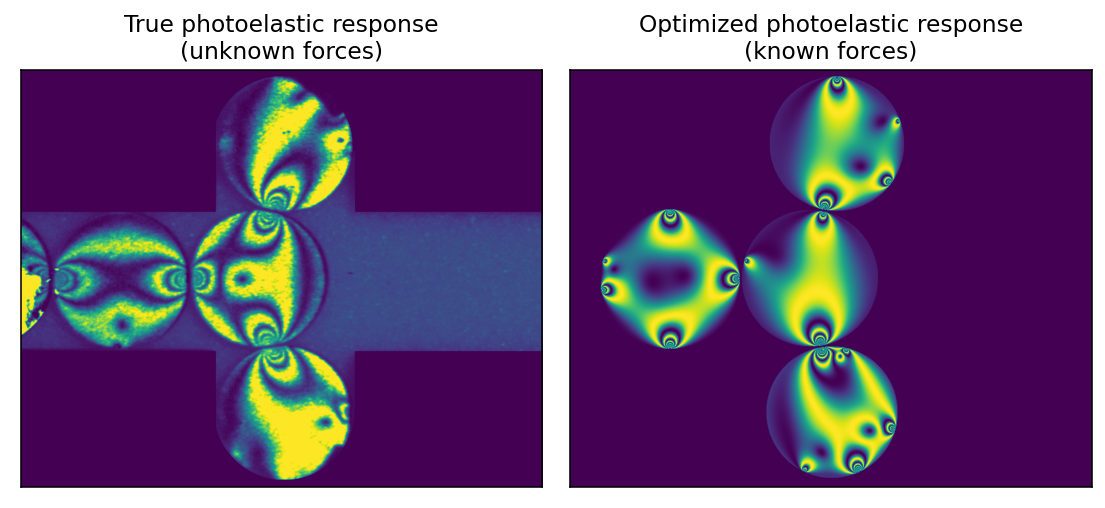

Absolute error (entire system): -79492.94891912272


In [48]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].imshow(photoelasticChannel * maskArr[:,:,0])
ax[0].set_title('True photoelastic response\n(unknown forces)')
ax[0].set_xticks([])
ax[0].set_yticks([])

optimizedPhotoelasticChannel = np.zeros(photoelasticChannel.shape)

for i in range(len(centers)):
    optimizedPhotoelasticChannel += genSyntheticResponse(np.array(optimizedForceArr[i]),
                                                         np.array(optimizedAlphaArr[i]),
                                                         np.array(optimizedBetaArr[i]),
                                                         fSigma, radii[i], pxPerMeter, brightfield,
                                                         imageSize=photoelasticChannel.shape, center=centers[i])


ax[1].imshow(optimizedPhotoelasticChannel)
ax[1].set_title('Optimized photoelastic response\n(known forces)')
ax[1].set_xticks([])
ax[1].set_yticks([])

fig.tight_layout()
#plt.savefig('../images/example_uses/space_jam_test.png')
plt.show()

print(f'Absolute error (entire system): {np.sum(optimizedPhotoelasticChannel - photoelasticChannel)}')

In [36]:
optimizedForceArr

[array([0.33005791, 0.09624589]),
 array([0.38587186, 0.03043315, 0.16621056, 0.23135342]),
 array([0.15623125, 0.01373373, 0.20722053, 0.08952546, 0.095551  ]),
 array([0.25454638, 0.09573109, 0.14185097, 0.04631533, 0.02808352,
        0.13380911])]

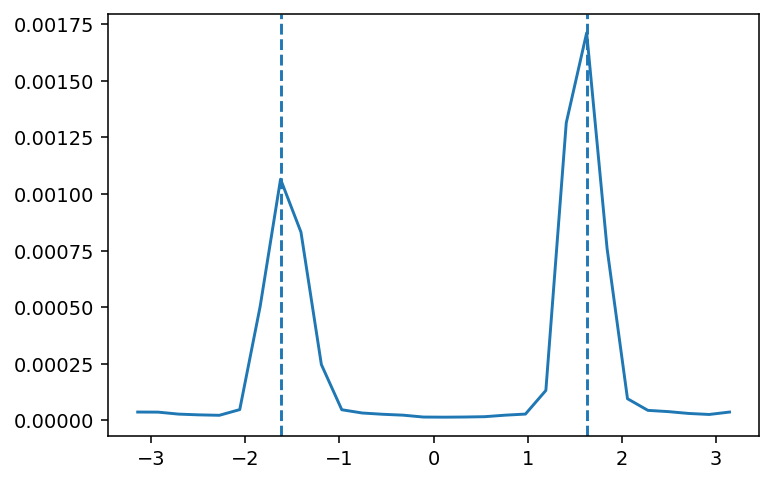

In [32]:
# To try and identify missing forces, take the average g2 in a ring
# around the edge of a particle
testParticle = 0
contactMaskRadius = 30.
steps = 30
newBetaTolerance = .3

avgG2Arr = np.zeros(steps)
betaArr = np.linspace(-np.pi, np.pi, steps)

gSqr = gSquared(photoelasticChannel)
particleMask = circularMask(photoelasticChannel.shape, centers[testParticle], radii[testParticle])[:,:,0]

for i in range(steps):
    contactPoint = centers[testParticle] + radii[testParticle] * np.array([np.cos(betaArr[i]), np.sin(betaArr[i])])
    
    contactMask = circularMask(photoelasticChannel.shape, contactPoint, contactMaskRadius)[:,:,0]
    contactMask = (contactMask + particleMask) == 2
    
    avgG2Arr[i] = np.sum(contactMask * gSqr) / np.sum(contactMask)
    
peakIndArr = find_peaks(avgG2Arr, height=.0003)[0]
peakIndArr = np.sort(peakIndArr)

# Make sure that there aren't any artifacts of periodicity
if np.arange(3).any() in peakIndArr and np.arange(len(avgG2Arr)-3, len(avgG2Arr)).any() in peakIndArr:
    print('overlap')
    # Remove last entry
    peakIndArr = peakIndArr[:-1]
    
peakBetas = betaArr[peakIndArr]

plt.plot(betaArr, avgG2Arr)

for i in range(len(peakBetas)):
    plt.axvline(peakBetas[i], linestyle='--')

plt.show()

In [39]:
# Now determine which of the found peaks is the most different
# from the ones already on the particle
oldBetaArr = betaGuessArr[testParticle]

differenceArr = np.abs(np.subtract.outer(peakBetas, oldBetaArr))

# Check to see if there is a new peak that doesn't have
# a previous force close to it
for i in range(len(peakBetas)):
    if differenceArr[i].all() > newBetaTolerance:
        # Add the new force

[[-3.19872539 -5.19819324 -4.3349155  -1.62496172]
 [ 0.05119804 -1.9482698  -1.08499207  1.62496172]]


In [57]:
# How do we identify when we need to add a force?
testParticle = 3
result = forceOptimize(forceGuessArr[testParticle], betaGuessArr[testParticle], alphaGuessArr[testParticle], radii[testParticle], centers[testParticle], photoelasticChannel,
                                        fSigma, pxPerMeter, brightfield, maxEvals=150, method='nelder',
                                        parametersToFit=['f', 'b'], betaTol=.4, returnOptResult=True)

In [51]:
print(fit_report(result))

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 151
    # data points      = 1
    # variables        = 8
    chi-square         = 2.1235e+08
    reduced chi-square = 2.1235e+08
    Akaike info crit   = 35.1737296
    Bayesian info crit = 19.1737296
##  Warning: uncertainties could not be estimated:
    b1:  at initial value
    b1:  at boundary
[[Variables]]
    f0:  0.14562618 (init = 0.07887012)
    b0:  1.57403837 (init = 1.573764)
    a0:  0 (fixed)
    f1:  1.7984e-06 (init = 0.0007153717)
    b1:  3.17321943 (init = 3.173232)
    a1:  0 (fixed)
    f2:  1.6545e-05 (init = 0.001082525)
    b2:  2.71007944 (init = 2.709954)
    a2:  0 (fixed)
    f3:  1.3637e-05 (init = 0.0005294987)
    b3:  9.2117e-05 (init = 0)
    a3:  0 (fixed)


In [59]:
result.chisqr

131785275.43311143